# Assignment: Unsupervised Machine Learning \ Genetic Algorithms

Extra Resoources: https://www.tutorialspoint.com/genetic_algorithms/index.htm

In this assignment you will experience with Genetic Algorithms (GAs), starting from a basic implementation, continuing with dedicated improvements, and later applying it in various unsupervised machine learning scenarios.

## Part 1: Time Series of 'Likes' Influenced by Personalization

Various personalization algorithms are applied in e-commerce and other kinds of websites/apps in order to increase purchases or user engagement.

The following time series were collected over a period of 20 months from a large online retail store. In this study, during the first 10 months (normalized as the period from month -10 to month 0) a contextual personalization algorithm was applied in order to increase user engagement (measured as the accumulated number of 'Likes' on products shared via Facebook). As in the case with many contextual approaches, this algorithm suffered from the 'filter bubble' problem (https://en.wikipedia.org/wiki/Filter_bubble), and therefore reached a plateau quite quickly.

Nonetheless, this step enabled a more advanced collaborative filtering algorithm to analyze the collected data, learn, and increase user engagement once it was applied in the following 10 months. A classic inflection point was detected after the transition to the new algorithm. A domain expert envisioned the inflection dynamics will behave similarly to the formula f(x) = ax^3 + bx^2 + cx + d. The values of a, b, c and d were found to be 4.8, 12.1, 53.2 and 6219, respectively.

<< Please note: This function is an analytical solution, used here for simplifying the actual study, where a dynamic model was created with ODEs >>

We are given a sample sparse data of users from 10 different European countries. In this project, we will implement a simple GA in order to fit our data to the above-mentioned function, and discover the parameters for a, b, c and d. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read measured data from an Excel file

In [2]:
xlsx = pd.ExcelFile('European Measurements.xlsx')
sheet1 = xlsx.parse(3) # Note the other datasets in the file.
variables = ["Month","Avg. Likes"]
data = sheet1.loc[:, variables].values
print(data)

[[-9.70000000e+00  1.93303385e+03]
 [-9.10000000e+00  3.07678202e+03]
 [-7.70000000e+00  4.61959427e+03]
 [-7.30000000e+00  4.87640388e+03]
 [-7.20000000e+00  5.27621777e+03]
 [-6.20000000e+00  5.76967851e+03]
 [-4.70000000e+00  5.26728526e+03]
 [-4.10000000e+00  6.40777934e+03]
 [-3.30000000e+00  6.05631612e+03]
 [-2.70000000e+00  6.10216500e+03]
 [-2.50000000e+00  5.18359545e+03]
 [-2.30000000e+00  7.03041233e+03]
 [-1.90000000e+00  5.69790109e+03]
 [-1.80000000e+00  5.42920417e+03]
 [-1.20000000e+00  5.23662184e+03]
 [-9.00000000e-01  6.28278124e+03]
 [-1.00000000e-01  6.53285159e+03]
 [ 2.00000000e-01  5.78284515e+03]
 [ 3.00000000e-01  6.57445814e+03]
 [ 4.00000000e-01  5.25761264e+03]
 [ 1.10000000e+00  5.86568880e+03]
 [ 1.50000000e+00  6.92127198e+03]
 [ 1.60000000e+00  6.15982519e+03]
 [ 2.10000000e+00  6.87265063e+03]
 [ 2.20000000e+00  5.57408399e+03]
 [ 2.50000000e+00  5.88485867e+03]
 [ 5.20000000e+00  6.75130936e+03]
 [ 5.40000000e+00  7.32399792e+03]
 [ 5.90000000e+00  7

### Simple GA mechanism

In [32]:
def fitness_function(data, pop):
    fitness = []
    for solution in range(len(pop)):
        error = 0
        for event in range(len(data)):
            event_time = data[event][0]
            event_measured = data[event][1]
            event_expected = pop[solution][0]*event_time**3 + pop[solution][1]*event_time**2 + pop[solution][2]*event_time + pop[solution][3] #differential equation
            error +=(event_expected - event_measured)**2
        fitness.append(1/error) # We use 1/error in order to use a maximization mechanism, while we want to minimize the error
    return fitness

def biased_selection(pop, fitness, num_parents):
    sorted_fitness_args = np.argsort(fitness) #Sort by the parents with the best scores
    return pop[sorted_fitness_args[-num_parents:],:] #take the amount of parents we decide on, who have the best scores.
    # parents = np.empty((num_parents, pop.shape[1]))
    # for parent_num in range(num_parents):
    #     max_fitness_idx = np.where(fitness == np.max(fitness))
    #     max_fitness_idx = max_fitness_idx[0][0]
    #     parents[parent_num, :] = pop[max_fitness_idx, :]
    #     fitness[max_fitness_idx] = -99999999999
    # return parents

def recombination(parents, offspring_size):
    offspring = np.empty(offspring_size)
    recombination_point = np.uint8(offspring_size[1]/2) #midway, or rounded midway.
    for k in range(offspring_size[0]): #For every potential child:
        parent1_idx = k%parents.shape[0] #The modulo prevents us from getting an error when k is passed array size. 
                                        #In such a case, P1 would be 0, and P2 would be 1
        parent2_idx = (k+1)%parents.shape[0]
        offspring[k, 0:recombination_point] = parents[parent1_idx, 0:recombination_point] #Isn't this not randomizing the columns in which each parent passes down to the kid? Maybe it doesn't matter?
        offspring[k, recombination_point:] = parents[parent2_idx, recombination_point:]
    return offspring

def mutation(offspring_recombination):
    for idx in range(offspring_recombination.shape[0]):
        random_value = np.random.randint(-100, 100, 1)
        random_index = np.random.randint(0,offspring_recombination.shape[1],1)
        offspring_recombination[idx, random_index] = offspring_recombination[idx, random_index] + random_value
    return offspring_recombination


### GA application for fitting time series data

The population of the first generation: 
[[1104 1346 8868 1656]
 [8958 1162 6731 8098]
 [8953 1779 7243 3044]
 ...
 [1895 6751 5060  863]
 [6895 4680 8937  744]
 [3999 6719 8615  401]]

Evolution:
Generation =  0 	Best fitness =  250762572371.17984
Generation =  1 	Best fitness =  250762572371.17984
Generation =  2 	Best fitness =  184413635291.77463
Generation =  3 	Best fitness =  184413635291.77463
Generation =  4 	Best fitness =  170289960501.41684
Generation =  5 	Best fitness =  170289960501.41684
Generation =  6 	Best fitness =  150304917743.51483
Generation =  7 	Best fitness =  150304917743.51483
Generation =  8 	Best fitness =  149560962356.32312
Generation =  9 	Best fitness =  97839565562.9284
Generation =  10 	Best fitness =  97839565562.9284
Generation =  11 	Best fitness =  7342519694.11006
Generation =  12 	Best fitness =  7285177745.36033
Generation =  13 	Best fitness =  3098735144.81551
Generation =  14 	Best fitness =  3098735144.81551
Generation =  15 	Best fitness

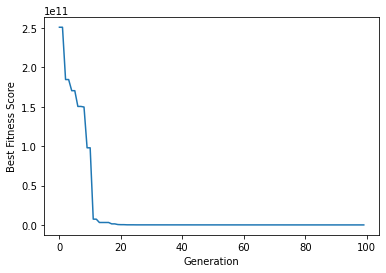

In [33]:
# GA Parameters
formula_degree = 4
number_of_solutions = 500
number_of_parents = 250
population_size = (number_of_solutions,formula_degree) #500 solutions, containing 4 coefficients each. The goal here is to find the best coefficients to the problem.
number_of_generations = 100
best_outputs = []

# Genesis
new_population = np.random.randint(low=0, high=10000, size=population_size)
print("The population of the first generation: ")
print(new_population)

# Evolution
print ("\nEvolution:")
for generation in range(number_of_generations):

    fitness = fitness_function(data, new_population) #returns 1/error for each solution.
    print("Generation = ", generation, "\tBest fitness = ", round(1/np.max(fitness),5))
    # best_outputs.append(np.max(np.sum(new_population*formula_degree, axis=1)))
    best_outputs.append(round(1/np.max(fitness),5))
    parents = biased_selection(new_population, fitness, number_of_parents) #Take the best parents
    offspring_recombination = recombination(parents, offspring_size=(population_size[0]-parents.shape[0], formula_degree)) #Note sure why this is the count for the offspring
    offspring_mutation = mutation(offspring_recombination)
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation #Mutate the last one only.

# Results
print("\nThe population of the last generation: ")
print(new_population)
fitness = fitness_function(data, new_population)
best_match_idx = np.where(fitness == np.max(fitness))
print("Best solution: ", new_population[best_match_idx, :])

# Chart
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.show()

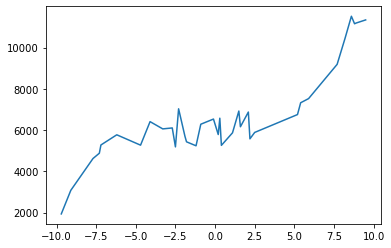

In [27]:
plt.plot(data[:, 0], data[:, 1])

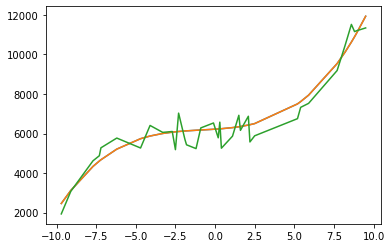

In [20]:
sol = [4.8, 12.1, 53.2, 6219]
plt.plot(data[:, 0], sol[0]*data[:, 0]**3 +sol[1]*data[:, 0]**2 + sol[2]*data[:, 0] + sol[3])
plt.plot(data[:, 0], sol[0]
*data[:, 0]**3 +sol[1]*data[:, 0]**2 + sol[2]*data[:, 0] + sol[3])
plt.plot(data[:, 0], data[:, 1])

In [34]:
best = new_population[best_match_idx, :].flatten()
best


array([   4,   29,   84, 5587])

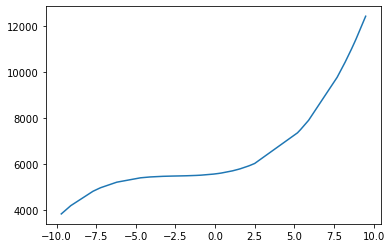

## Challenge 231 (_max score - 50 points_)
Implement a new and improved GA, based on the one above, by taking the following actions:

1. Make the bias_selection function give more chances to solutions with better fitness values, but not necesseraly take the best ones, as currently done.
2. Make the recombination function make real random recombination along the chromosome and between chromosomes
3. Change the mutation rate and/or scale to better avoid local minima while keeping evolution time short
4. Apply a smarter stopping criterion
5. Consider different GA parameters in order to reach better results

In [48]:
def fitness_function(data, pop):
    fitness = []
    for solution in range(len(pop)):
        error = 0
        for event in range(len(data)):
            event_time = data[event][0]
            event_measured = data[event][1]
            event_expected = pop[solution][0]*event_time**3 + pop[solution][1]*event_time**2 + pop[solution][2]*event_time + pop[solution][3] #differential equation
            error +=(event_expected - event_measured)**2
        fitness.append(1/error) 
    return fitness

def biased_selection(pop, fitness, num_parents): #1st change) created a random choice of parents to produce, based off their accuracies.
    select = np.random.choice(np.array(list(enumerate(fitness)))[:, 0], size = (num_parents), p = (fitness/np.sum(fitness)), replace= False)
    parents = pop[select.astype(int)]
    return parents

def recombination(parents, offspring_size):
    offspring = np.empty(offspring_size)
    recombination_point = np.random.choice(np.uint8(offspring_size[1])) #Change 2) Random amount of chromosomes taken from each parents (meaning, not necessarily 50:50)
    for k in range(offspring_size[0]): 
        parent1_idx = k%parents.shape[0]
                                        
        parent2_idx = (k+1)%parents.shape[0]
        offspring[k, 0:recombination_point] = parents[parent1_idx, 0:recombination_point] 
        offspring[k, recombination_point:] = parents[parent2_idx, recombination_point:]
    return offspring

def mutation(offspring_recombination):
    mutate = np.random.randint(0, offspring_recombination.shape[0], 125) #only mutate 200 instead of 250
    for idx in mutate: #select idx of those we are mutating
        random_value = np.random.choice([np.random.randint(-400,-100), np.random.randint(100,400)]) #Take higher ranges of mutation
        random_index = np.random.randint(0,offspring_recombination.shape[1],1)
        offspring_recombination[idx, random_index] = offspring_recombination[idx, random_index] + random_value
    return offspring_recombination

The population of the first generation: 
[[6545 5841 9380 1686]
 [3924 9262 6901 1067]
 [3887 9895 7597 2451]
 ...
 [5926 7771 2732 5400]
 [8487 1100 7439 2713]
 [6423 9210 1287 8427]]

Evolution:
Generation =  0 	Best fitness =  309364849158.60065
Generation =  1 	Best fitness =  16290919505.19554
Generation =  2 	Best fitness =  16290919505.19554
Generation =  3 	Best fitness =  2879576978.47353
Generation =  4 	Best fitness =  2879576978.47353
Generation =  5 	Best fitness =  2879576978.47353
Generation =  6 	Best fitness =  2810300893.10859
Generation =  7 	Best fitness =  2810300893.10859
Generation =  8 	Best fitness =  404455873.18818
Generation =  9 	Best fitness =  404455873.18818
Generation =  10 	Best fitness =  404455873.18818
Generation =  11 	Best fitness =  135016064.67969
Generation =  12 	Best fitness =  135016064.67969
Generation =  13 	Best fitness =  135016064.67969
Generation =  14 	Best fitness =  128396444.6162
Generation =  15 	Best fitness =  128396444.6162
Gen

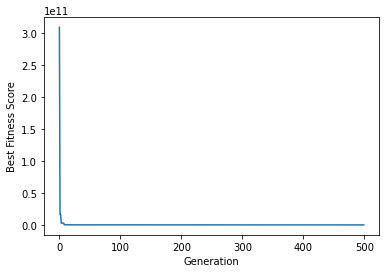

In [49]:
# GA Parameters
formula_degree = 4
number_of_solutions = 500
number_of_parents = 250
population_size = (number_of_solutions,formula_degree) #500 solutions, containing 4 coefficients each. The goal here is to find the best coefficients to the problem.
number_of_generations = 500
best_outputs = []

# Genesis
new_population = np.random.randint(low=0, high=10000, size=population_size)
print("The population of the first generation: ")
print(new_population)

# Evolution
print ("\nEvolution:")
for generation in range(number_of_generations):

    fitness = fitness_function(data, new_population) #returns 1/error for each solution.
    print("Generation = ", generation, "\tBest fitness = ", round(1/np.max(fitness),5))
    # best_outputs.append(np.max(np.sum(new_population*formula_degree, axis=1)))
    best_outputs.append(round(1/np.max(fitness),5))
    parents = biased_selection(new_population, fitness, number_of_parents) #Take the best parents
    offspring_recombination = recombination(parents, offspring_size=(population_size[0]-parents.shape[0], formula_degree)) #Note sure why this is the count for the offspring
    offspring_mutation = mutation(offspring_recombination)
    new_population[0:parents.shape[0], :] =  parents #New population is the selected parents (we get rid of the rest), and the new children.
    new_population[parents.shape[0]:, :] = offspring_mutation #Add offspring to the population, with one of the offspring having a mutation

# Results
print("\nThe population of the last generation: ")
print(new_population)
fitness = fitness_function(data, new_population)
best_match_idx = np.where(fitness == np.max(fitness))
print("Best solution: ", new_population[best_match_idx, :])

# Chart
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.show()

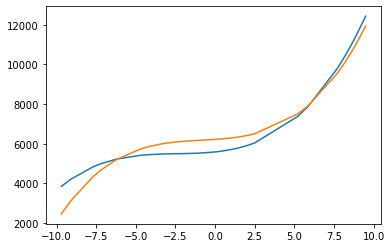

In [52]:
plt.plot(data[:, 0], best[0]*data[:, 0]**3 +best[1]*data[:, 0]**2 + best[2]*data[:, 0] + best[3])
sol = [4.8, 12.1, 53.2, 6219]
plt.plot(data[:, 0], sol[0]*data[:, 0]**3 +sol[1]*data[:, 0]**2 + sol[2]*data[:, 0] + sol[3])


## Part 2: Solving Different Problems With the Same GA

Below is a reminder of the K-Means algorithm you implemented in HW1.

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  app.launch_new_instance()


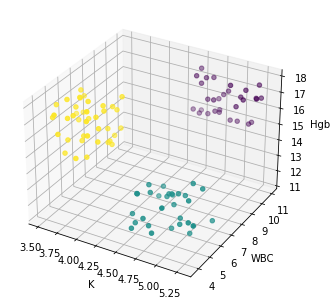

In [3]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import calinski_harabasz_score

xlsx = pd.ExcelFile('EMR-Blood (1).xlsx')
sheet1 = xlsx.parse(0)
sheet1.set_index("Key", inplace=True)

variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

y_pred_KMeans1 = KMeans(n_clusters=3).fit_predict(EMR3d1)

def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred)

make_chart(EMR3d1, y_pred_KMeans1, variables1)

## Challenge 232 (_max score - 50 points_)
Solve the same clustering problem with a GA **without assuming K** (no iteration over differnet Ks), by trying to minimize the intra-cluster distances and maximize the inter-cluster distances.

**hint: You can build the population as the cluster assignment of each point or as cluster centers (consider coordinates boundaries)

In [123]:
# def fitness_function(X, parents):
    
#     fitness = []
    
#     for parent in parents:
#         y = parent
#         distances = []
#         centroids = []
#         for cent in  np.unique(y):
#             cluster = X[y == cent]
#             centroid = cluster.mean(axis = 0)
#             distances.append(np.linalg.norm(cluster - centroid))
#             centroids.append(centroid)
       
#         WCSS = np.mean(distances)
#         # TSS = np.sum(np.square(X- X.mean())**2)
#         # BCSS = TSS - WCSS

#         BCSS = np.mean(np.linalg.norm(centroids - X.mean()))
#         fitness.append(1/(WCSS/BCSS))

#     return fitness
def fitness_function(X, parents):
    
    fitness = []
    
    for parent in parents:
        score = calinski_harabasz_score(X, parent)
        fitness.append(score)

    return fitness

def biased_selection(pop, fitness, num_parents):
    sorted_fitness_args = np.argsort(fitness) #Sort by the parents with the best scores
    return pop[sorted_fitness_args[-num_parents:],:] #take the amount of parents we decide on, who have the best scores.
    # select = np.random.choice(np.array(list(enumerate(fitness)))[:, 0], size = (num_parents), p = (fitness/np.sum(fitness)), replace= False)
    # parents = pop[select.astype(int)]
    # return parents
    

def recombination(parents, offspring_size):
    offspring = np.empty(offspring_size)
    # recombination_point = np.random.choice(np.uint8(offspring_size[1]))
    recombination_point = np.random.choice(np.uint8(offspring_size[1]))
    for k in range(offspring_size[0]): #For every potential child:
        parent1_idx = k%parents.shape[0] #The modulo prevents us from getting an error when k is passed array size. 
        partner = np.random.randint(0,8)                                #In such a case, P1 would be 0, and P2 would be 1
        parent2_idx = (k+partner)%parents.shape[0]
        offspring[k, 0:recombination_point] = parents[parent1_idx, 0:recombination_point] #Isn't this not randomizing the columns in which each parent passes down to the kid? Maybe it doesn't matter?
        offspring[k, recombination_point:] = parents[parent2_idx, recombination_point:]
    return offspring

def mutation(offspring_recombination, mutation_range):
    for idx in range(0, offspring_recombination.shape[0]):
        random_value = np.random.randint(0, mutation_range, 1)
        random_index = np.random.randint(0, offspring_recombination.shape[1] , 1)
        offspring_recombination[idx, random_index] = random_value
        random_value = np.random.randint(0, mutation_range, 1)
        # rand_cluster_idx = np.random.choice(np.unique(offspring_recombination[idx]))
        # random_index = np.where(offspring_recombination[idx] == rand_cluster_idx)
        # offspring_recombination[idx, np.array(random_index).flatten()] = random_value
    return offspring_recombination


In [124]:
np.array(np.where(new_population[0] == 1)).flatten()

array([ 0,  3,  6, 10, 16, 20, 23, 26, 43, 46, 50, 53, 56, 60, 63, 66, 76,
       83, 90, 93, 96], dtype=int64)

The population of the first generation: 
[[5 1 1 ... 4 3 1]
 [1 4 1 ... 1 1 6]
 [3 3 1 ... 0 4 6]
 ...
 [4 4 1 ... 0 1 6]
 [0 5 5 ... 3 0 4]
 [6 0 0 ... 0 6 1]]

Evolution:
Generation =  0 	Best fitness =  2.72253
Generation =  1 	Best fitness =  3.21222
Generation =  2 	Best fitness =  3.4911
Generation =  3 	Best fitness =  3.4911
Generation =  4 	Best fitness =  4.65445
Generation =  5 	Best fitness =  4.95599
Generation =  6 	Best fitness =  4.95599
Generation =  7 	Best fitness =  4.96243
Generation =  8 	Best fitness =  4.96243
Generation =  9 	Best fitness =  5.14665
Generation =  10 	Best fitness =  5.17804
Generation =  11 	Best fitness =  7.75076
Generation =  12 	Best fitness =  7.75076
Generation =  13 	Best fitness =  7.75076
Generation =  14 	Best fitness =  7.75076
Generation =  15 	Best fitness =  7.75076
Generation =  16 	Best fitness =  7.75076
Generation =  17 	Best fitness =  7.75076
Generation =  18 	Best fitness =  7.75076
Generation =  19 	Best fitness =  8.00248

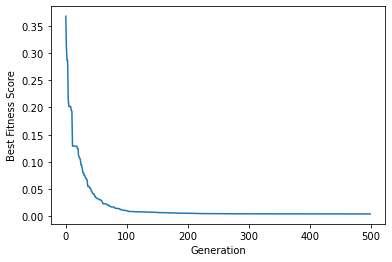

In [125]:
# GA Parameters
formula_degree = EMR3d1.shape[0]
number_of_solutions = 500
number_of_parents = 250
starting_clusters = 7
population_size = (number_of_solutions,formula_degree) #500 solutions, containing 4 coefficients each. The goal here is to find the best coefficients to the problem.
number_of_generations = 500
best_outputs = []
data = EMR3d1

best_labels = None

# Genesis
new_population = np.random.randint(low=0, high=starting_clusters, size=population_size)
print("The population of the first generation: ")
print(new_population)

stop_log = 0
prev_score = 0

# Evolution
print ("\nEvolution:")
for generation in range(number_of_generations):
    fitness = fitness_function(data, new_population) #returns 1/error for each solution.
    print("Generation = ", generation, "\tBest fitness = ", round(np.max(fitness),5))
    # best_outputs.append(np.max(np.sum(new_population*formula_degree, axis=1)))
    best_outputs.append(round(1/np.max(fitness),5))
    best_labels = new_population[np.argmax(fitness)].copy()
    parents = biased_selection(new_population, fitness, number_of_parents) #Take the best parents
    offspring_recombination = recombination(parents, offspring_size=(population_size[0]-parents.shape[0], formula_degree)) #Note sure why this is the count for the offspring
    offspring_mutation = mutation(offspring_recombination, starting_clusters)
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation #Mutate the last one only.

    #Create stop threshold:
    best_score = round(np.max(fitness),5)
    if best_score == prev_score:
        stop_log+=1
    else:
        stop_log= 0
    prev_score = best_score
    if stop_log ==100:
        break
    
# Results
print("\nThe population of the last generation: ")
print(new_population)
fitness = fitness_function(data, new_population)
best_match_idx = np.where(fitness == np.max(fitness))
print("Best solution: ", new_population[best_match_idx, :])

print(f'stopped at {generation} generations')

# Chart
plt.plot(best_outputs)
plt.xlabel("Generation")
plt.ylabel("Best Fitness Score")
plt.show()

In [128]:
calinski_harabasz_score(EMR3d1, best_labels )

216.6651858322499

C:\Users\sfrie\anaconda3\envs\py4dp\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  app.launch_new_instance()


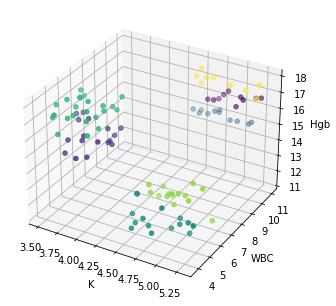

In [129]:
make_chart(EMR3d1, new_population[np.argmax(fitness)], variables1)

## Challenge 233: Reconstruct Image (Bonus: _max score - 20 points_)
In this part you will attemp to generate an image which is closest to a target image given. 

First we will load the image from a file:


In [ ]:
import matplotlib.image as mpimg

img=mpimg.imread('pexels-photo-57905.jpeg')

For simplicity (and running time), we focus on a small part of the image:

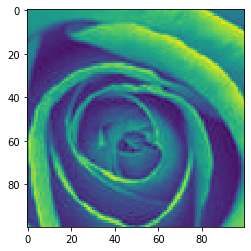

In [ ]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(img[100:200,200:300,0])

And we will define this part as out target image to reconstruct:

In [ ]:
target = img[100:200,200:300,0]

Your mission is to generate an image starting at random noise. The goal is to get an image as close as possible to the target. Don;t worry if it's still noisy...
FYI: GA are not the best solution for these types of problems ;)
You can use these blog posts to give you ideas:
https://towardsdatascience.com/genetic-algorithm-implementation-in-python-5ab67bb124a6

https://heartbeat.fritz.ai/reproducing-images-using-a-genetic-algorithm-with-python-91fc701ff84

In [ ]:
# Your code here